# Sales Prediction - Time Series Problem using Deep Learning - RNN

## Importing Libraries

In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU, Conv1D, MaxPooling1D, Flatten, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Reading Data & Preprocessing

In [2]:
#Returns a numpy array with size nrows x ncolumns-1. nrows and ncolums are the rows and columns of the dataset
#the Date column is skipped (ncolumns-1)
def readData(fname):
    with open(fname) as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    header = lines[0].split(",")
    lines = lines[1:] 
    #print(header) 
    #print("Data rows: ", len(lines))

    rawData = np.zeros((len(lines), len(header)-1)) #skip the Date column

    for i, aLine in enumerate(lines):       
        splittedLine = aLine.split(",")[:]
        rawData[i, 0] = splittedLine[0]
        rawData[i, 1:] = [float(x) for x in splittedLine[2:]] 

    return rawData

In [3]:
#Returns the train and test data, normalized. It also returns the standard deviation of Weekly_Sales
#Each list has a size equal to the number of stores
#For each store there is a list of size trainNSaples (testNSamples) x nColums-1 (the store id is skipped)
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
def splitTrainTest(rawData, testPercent):

    listStore = np.unique(rawData[:, 0])
    trainNSamples = np.zeros(len(listStore))
    
    for i, storeId in enumerate(listStore):
        trainNSamples[i] = np.count_nonzero(rawData[:, 0] == storeId)
    trainNSamples = np.floor((1-testPercent) *  trainNSamples)

    tmpTrain = np.zeros((int(np.sum(trainNSamples)), len(rawData[0])))

    store = -1
    counter = 0
    counterTrain = 0
    storeDict = dict(zip(listStore, trainNSamples))
    for i, aLine in enumerate(rawData):
        if store != aLine[0]:
            store = int(aLine[0])
            counter = 0
        if(counter < storeDict.get(store)):
            tmpTrain[counterTrain] = rawData[i][:]
            counterTrain += 1
            counter += 1

    meanData = tmpTrain.mean(axis=0)
    stdData = tmpTrain.std(axis=0)
    rawNormData = (rawData - meanData) / stdData

    allTrain = list()
    allTest = list()
    store = -1
    counter = 0
    for i, aLine in enumerate(rawNormData):
        splittedLine = [float(x) for x in aLine[1:]] #skip store id
        if store != rawData[i][0]:
            if i != 0:
                allTrain.append(storeDataTrain)
                allTest.append(storeDataTest)
            store = int(rawData[i][0])
            storeDataTrain = list()
            storeDataTest = list()
            counter = 0

        if(counter < storeDict.get(store)):
            storeDataTrain.append(splittedLine)
            counter += 1
        else:
            storeDataTest.append(splittedLine)

        if i == len(rawNormData)-1:
            allTrain.append(storeDataTrain)
            allTest.append(storeDataTest)

    return allTrain, allTest, stdData[1] #std of wSales

In [4]:
#generates a time series given the input and ouput data, the sequence length and the batch size
#seqLength is the number of weeks (observations) of data to be used as input
#the target will be the weekly sales in 2 weeks
def generateTimeSeries(data, wSales, seqLength, batchSize):   
    sampling_rate = 1 #keep all the data points 
    weeksInAdvance = 3
    delay = sampling_rate * (seqLength + weeksInAdvance - 1) #the target will be the weekly sales in 2 weeks
    
    dataset = keras.utils.timeseries_dataset_from_array(
        data[:-delay],
        targets=wSales[delay:],
        sampling_rate=sampling_rate,
        sequence_length=seqLength,
        shuffle=True,
        batch_size=batchSize,
        start_index=0)
    
    return dataset


In [5]:
def printTimeSeriesList(theList):
    print('list length', len(theList))
    print('First element')
    input, target = theList[0]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])
    print('Last element')
    input, target = theList[-1]
    print([float(x) for x in input.numpy().flatten()], [float(x) for x in target.numpy().flatten()])

In [6]:
#returns the training and test time series
#it also returns the standard deviation of Weekly_Sales, and the number of input features
def generateTrainTestData(fileName, testPercent, seqLength, batchSize):
    rawData = readData(os.path.join(fileName))
    allTrain, allTest, stdSales = splitTrainTest(rawData, testPercent)
    
    for i in range(len(allTrain)):
        tmp_train = generateTimeSeries(np.array(allTrain[i]), np.array(allTrain[i])[:,0], seqLength, batchSize)
        tmp_test = generateTimeSeries(np.array(allTest[i]), np.array(allTest[i])[:,0], seqLength, batchSize)

        if i == 0:
            train_dataset = tmp_train
            test_dataset = tmp_test
        else:
            train_dataset = train_dataset.concatenate(tmp_train)
            test_dataset = test_dataset.concatenate(tmp_test)
    
    return train_dataset, test_dataset, stdSales, np.shape(allTrain)[2]

In [7]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = 8
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

## Modeling

### 1st Arch. Selection

As a first step, 1 basic LSTM model will trained, then 3 combinations will be made which represented in using LSTM with: GRU, CNN and Dense and trying to keep the arch. as is for comparison (same number of nuerons, same activation function, optimizer etc.). These 4 initial Architecture will determine which combination will be adopted for the first model, then several experiments will be done on the winner model to test in in depth. As a result, either the final model will be considered or another architecture wil be chosen and tested again. 

The metrics of selecting a model are: 

- Avoiding overfitting and/or underfitting
- Mean Square Error: the target is 68,000 after denormalization


LSTM Model

In [9]:
# Define the model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)


Epoch 1/50
4365/4365 [==============================] - 42s 9ms/step - loss: 0.1928 - mae: 0.2875 - val_loss: 0.2081 - val_mae: 0.3524
Epoch 2/50
4365/4365 [==============================] - 36s 8ms/step - loss: 0.1202 - mae: 0.2365 - val_loss: 0.1672 - val_mae: 0.3084
Epoch 3/50
4365/4365 [==============================] - 37s 8ms/step - loss: 0.0896 - mae: 0.2073 - val_loss: 0.1133 - val_mae: 0.2533
Epoch 4/50
4365/4365 [==============================] - 37s 9ms/step - loss: 0.0799 - mae: 0.1961 - val_loss: 0.0916 - val_mae: 0.2215
Epoch 5/50
4365/4365 [==============================] - 38s 9ms/step - loss: 0.0735 - mae: 0.1906 - val_loss: 0.0948 - val_mae: 0.2235
Epoch 6/50
4365/4365 [==============================] - 38s 9ms/step - loss: 0.0707 - mae: 0.1862 - val_loss: 0.0927 - val_mae: 0.2192
Epoch 7/50
4365/4365 [==============================] - 38s 9ms/step - loss: 0.0675 - mae: 0.1847 - val_loss: 0.0864 - val_mae: 0.2042
Epoch 8/50
4365/4365 [==============================] -

540/540 [==============================] - 2s 3ms/step - loss: 0.0420 - mae: 0.1468
Normalized MAE:  0.14680176973342896
Denormalized MAE:  83949.29374298309


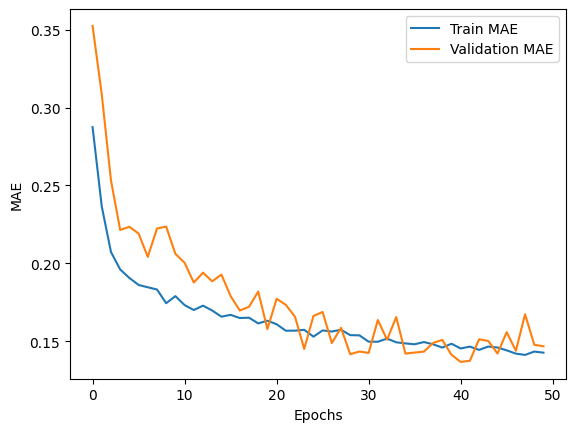

In [11]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

there is no overfitting and underfitting, the mae is far from the target (almost 23% error)

LSTM + GRU Model

In [15]:

# Define the model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    GRU(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    GRU(16, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)




Epoch 1/50
4365/4365 [==============================] - 55s 12ms/step - loss: 0.2009 - mae: 0.2972 - val_loss: 0.2687 - val_mae: 0.4150
Epoch 2/50
4365/4365 [==============================] - 50s 11ms/step - loss: 0.1584 - mae: 0.2646 - val_loss: 0.2157 - val_mae: 0.3489
Epoch 3/50
4365/4365 [==============================] - 50s 11ms/step - loss: 0.1347 - mae: 0.2460 - val_loss: 0.1325 - val_mae: 0.2816
Epoch 4/50
4365/4365 [==============================] - 50s 11ms/step - loss: 0.1117 - mae: 0.2278 - val_loss: 0.1120 - val_mae: 0.2432
Epoch 5/50
4365/4365 [==============================] - 50s 11ms/step - loss: 0.0978 - mae: 0.2174 - val_loss: 0.1165 - val_mae: 0.2245
Epoch 6/50
4365/4365 [==============================] - 50s 11ms/step - loss: 0.0871 - mae: 0.2076 - val_loss: 0.0886 - val_mae: 0.2135
Epoch 7/50
4365/4365 [==============================] - 50s 12ms/step - loss: 0.0869 - mae: 0.2102 - val_loss: 0.1222 - val_mae: 0.2489
Epoch 8/50
4365/4365 [==========================

In [16]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)



540/540 [==============================] - 2s 4ms/step - loss: 0.0469 - mae: 0.1591
Normalized MAE:  0.15911784768104553


In [17]:
# Denormalize the MAE
denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)


Denormalized MAE:  90992.30178889018


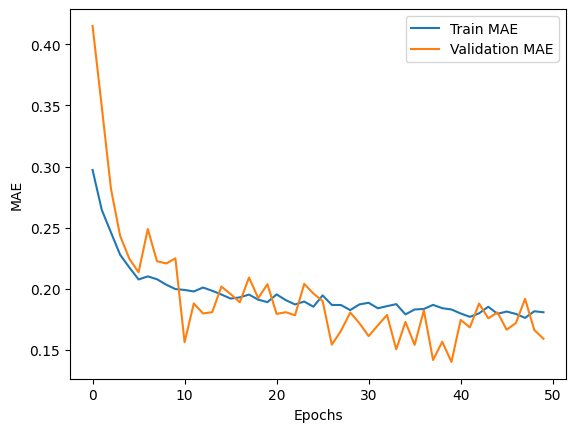

In [18]:

# Plot the training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

There is fluctuation in the validation mae, in addition to that it's lower than the previous model

LSTM + Conv

In [19]:
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(seqLength, nFeatures)),
    MaxPooling1D(pool_size=2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)

Epoch 1/50
4365/4365 [==============================] - 29s 6ms/step - loss: 0.2071 - mae: 0.2916 - val_loss: 0.2238 - val_mae: 0.3626
Epoch 2/50
4365/4365 [==============================] - 25s 6ms/step - loss: 0.1316 - mae: 0.2396 - val_loss: 0.2172 - val_mae: 0.3457
Epoch 3/50
4365/4365 [==============================] - 24s 6ms/step - loss: 0.0932 - mae: 0.2120 - val_loss: 0.1903 - val_mae: 0.3229
Epoch 4/50
4365/4365 [==============================] - 24s 5ms/step - loss: 0.0866 - mae: 0.2035 - val_loss: 0.1943 - val_mae: 0.3254
Epoch 5/50
4365/4365 [==============================] - 23s 5ms/step - loss: 0.0779 - mae: 0.1948 - val_loss: 0.1602 - val_mae: 0.2939
Epoch 6/50
4365/4365 [==============================] - 24s 5ms/step - loss: 0.0762 - mae: 0.1917 - val_loss: 0.1601 - val_mae: 0.2810
Epoch 7/50
4365/4365 [==============================] - 23s 5ms/step - loss: 0.0784 - mae: 0.1914 - val_loss: 0.1457 - val_mae: 0.2716
Epoch 8/50
4365/4365 [==============================] -

In [20]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)

540/540 [==============================] - 2s 3ms/step - loss: 0.0601 - mae: 0.1749
Normalized MAE:  0.17486421763896942


In [21]:
# Denormalize the MAE
denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

Denormalized MAE:  99996.93871788506


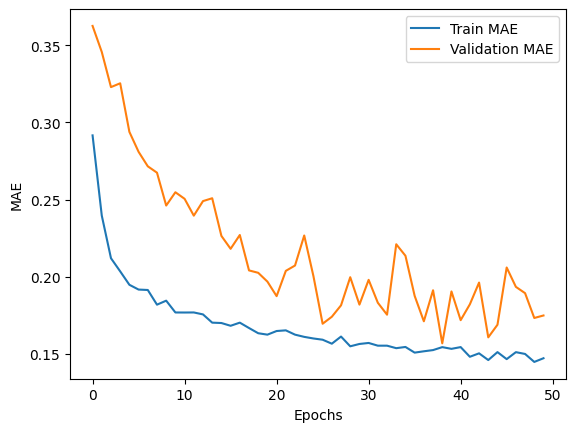

In [22]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

both flactuation and mae value are worse than previous two models

LSTM + Dense

In [23]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(seqLength, nFeatures)),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)

Epoch 1/50
4365/4365 [==============================] - 38s 8ms/step - loss: 0.1865 - mae: 0.2741 - val_loss: 0.2363 - val_mae: 0.3878
Epoch 2/50
4365/4365 [==============================] - 33s 8ms/step - loss: 0.1391 - mae: 0.2440 - val_loss: 0.2629 - val_mae: 0.4044
Epoch 3/50
4365/4365 [==============================] - 33s 8ms/step - loss: 0.1072 - mae: 0.2264 - val_loss: 0.1683 - val_mae: 0.2963
Epoch 4/50
4365/4365 [==============================] - 33s 8ms/step - loss: 0.1003 - mae: 0.2195 - val_loss: 0.1521 - val_mae: 0.2989
Epoch 5/50
4365/4365 [==============================] - 33s 8ms/step - loss: 0.0916 - mae: 0.2064 - val_loss: 0.1511 - val_mae: 0.3041
Epoch 6/50
4365/4365 [==============================] - 33s 8ms/step - loss: 0.0852 - mae: 0.2003 - val_loss: 0.1451 - val_mae: 0.2935
Epoch 7/50
4365/4365 [==============================] - 34s 8ms/step - loss: 0.0813 - mae: 0.1990 - val_loss: 0.0970 - val_mae: 0.2287
Epoch 8/50
4365/4365 [==============================] -

In [24]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


540/540 [==============================] - 2s 4ms/step - loss: 0.0839 - mae: 0.2007
Normalized MAE:  0.2006652057170868


In [25]:
# Denormalize the MAE
denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

Denormalized MAE:  114751.35708056678


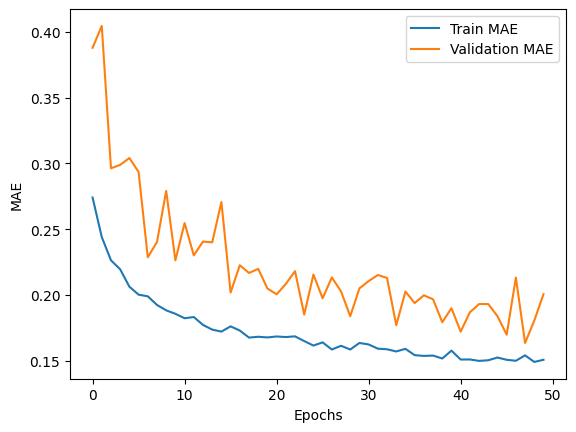

In [26]:
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Based on above four expirements, LSTM alone model was the best one as a initial model for further expirements, in the next section, the best possible model will be figured out while chaning some parameters.

### Going Further in LSTM Model

The following parameters will be changed in order to find the best possible model:

- number of nuerons
- activation function
- drop out value
- sequence length

#### Number of nuerons

128 & 64

In [8]:
# Define the model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(64, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)

Epoch 1/50
4365/4365 [==============================] - 83s 17ms/step - loss: 0.1687 - mae: 0.2607 - val_loss: 0.1836 - val_mae: 0.3190
Epoch 2/50
4365/4365 [==============================] - 60s 14ms/step - loss: 0.1085 - mae: 0.2171 - val_loss: 0.1567 - val_mae: 0.2960
Epoch 3/50
4365/4365 [==============================] - 67s 15ms/step - loss: 0.0801 - mae: 0.1919 - val_loss: 0.1563 - val_mae: 0.2849
Epoch 4/50
4365/4365 [==============================] - 57s 13ms/step - loss: 0.0700 - mae: 0.1814 - val_loss: 0.1078 - val_mae: 0.2385
Epoch 5/50
4365/4365 [==============================] - 58s 13ms/step - loss: 0.0640 - mae: 0.1780 - val_loss: 0.1084 - val_mae: 0.2399
Epoch 6/50
4365/4365 [==============================] - 57s 13ms/step - loss: 0.0629 - mae: 0.1738 - val_loss: 0.0875 - val_mae: 0.2165
Epoch 7/50
4365/4365 [==============================] - 57s 13ms/step - loss: 0.0599 - mae: 0.1696 - val_loss: 0.0759 - val_mae: 0.2031
Epoch 8/50
4365/4365 [==========================

540/540 [==============================] - 3s 5ms/step - loss: 0.0371 - mae: 0.1334
Normalized MAE:  0.13341376185417175
Denormalized MAE:  76293.29744178044


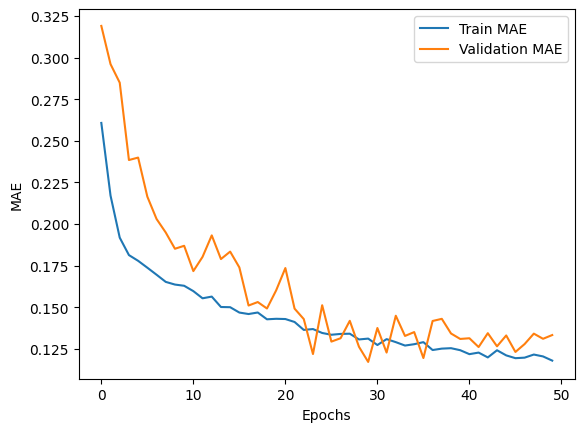

In [9]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)

denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

when considering higher numeber of neurons, the model significantly improved, the error to target now is 12% instead of 23%, therefore more exirements will be condicted by increasing the number of nuerons

256 & 128

In [14]:
# Define the model
model = Sequential([
    LSTM(256, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)

Epoch 1/50
4365/4365 [==============================] - 73s 16ms/step - loss: 0.1628 - mae: 0.2565 - val_loss: 0.2310 - val_mae: 0.3656
Epoch 2/50
4365/4365 [==============================] - 79s 18ms/step - loss: 0.0948 - mae: 0.2039 - val_loss: 0.2162 - val_mae: 0.3444
Epoch 3/50
4365/4365 [==============================] - 81s 19ms/step - loss: 0.0719 - mae: 0.1840 - val_loss: 0.1499 - val_mae: 0.2801
Epoch 4/50
4365/4365 [==============================] - 82s 19ms/step - loss: 0.0642 - mae: 0.1769 - val_loss: 0.1334 - val_mae: 0.2651
Epoch 5/50
4365/4365 [==============================] - 79s 18ms/step - loss: 0.0616 - mae: 0.1708 - val_loss: 0.1068 - val_mae: 0.2352
Epoch 6/50
4365/4365 [==============================] - 88s 20ms/step - loss: 0.0562 - mae: 0.1651 - val_loss: 0.1287 - val_mae: 0.2713
Epoch 7/50
4365/4365 [==============================] - 85s 20ms/step - loss: 0.0547 - mae: 0.1623 - val_loss: 0.0797 - val_mae: 0.2057
Epoch 8/50
4365/4365 [==========================

540/540 [==============================] - 2s 4ms/step - loss: 0.0327 - mae: 0.1294
Normalized MAE:  0.12944166362285614
Denormalized MAE:  74021.83408134409


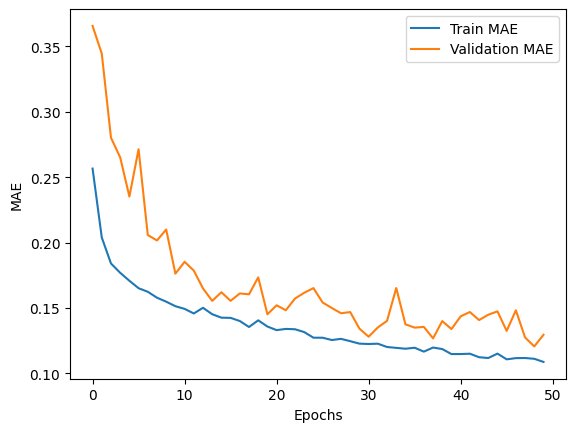

In [15]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Based on above result, It's slighlty better when using 256 with 128 neurons in the first and second layers. 

512 & 128

In [16]:
# Define the model
model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(trainData, epochs=50, validation_data=testData)

Epoch 1/50
4365/4365 [==============================] - 207s 46ms/step - loss: 0.1638 - mae: 0.2520 - val_loss: 0.3107 - val_mae: 0.4446
Epoch 2/50
4365/4365 [==============================] - 206s 47ms/step - loss: 0.1020 - mae: 0.2132 - val_loss: 0.2212 - val_mae: 0.3613
Epoch 3/50
4365/4365 [==============================] - 232s 53ms/step - loss: 0.0782 - mae: 0.1918 - val_loss: 0.1387 - val_mae: 0.2781
Epoch 4/50
4365/4365 [==============================] - 230s 53ms/step - loss: 0.0655 - mae: 0.1783 - val_loss: 0.1187 - val_mae: 0.2671
Epoch 5/50
4365/4365 [==============================] - 222s 51ms/step - loss: 0.0653 - mae: 0.1738 - val_loss: 0.0940 - val_mae: 0.2308
Epoch 6/50
4365/4365 [==============================] - 200s 46ms/step - loss: 0.0578 - mae: 0.1672 - val_loss: 0.0775 - val_mae: 0.2060
Epoch 7/50
4365/4365 [==============================] - 203s 47ms/step - loss: 0.0547 - mae: 0.1636 - val_loss: 0.0725 - val_mae: 0.2073
Epoch 8/50
4365/4365 [===================

540/540 [==============================] - 5s 9ms/step - loss: 0.0304 - mae: 0.1252
Normalized MAE:  0.1251748502254486
Denormalized MAE:  71581.83644442259


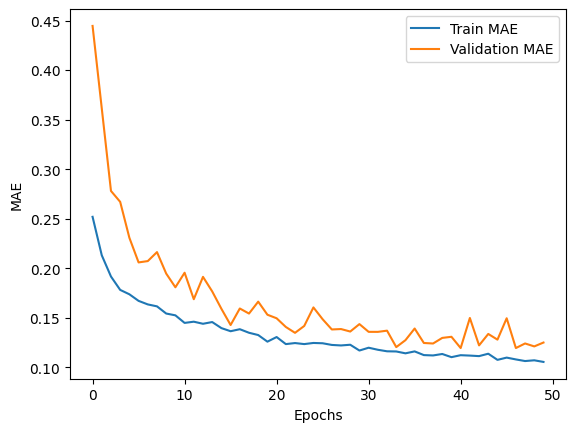

In [17]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

still getting better, and now we are not far from our target, one further model will be built using 512 and 256, as more than that the computation will be too complex and needs huge amount of time.

512 & 256

In [9]:

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Define the model
model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[early_stop])


Epoch 1/50
4365/4365 [==============================] - 396s 89ms/step - loss: 0.1579 - mae: 0.2455 - val_loss: 0.2994 - val_mae: 0.4214
Epoch 2/50
4365/4365 [==============================] - 400s 92ms/step - loss: 0.0924 - mae: 0.2043 - val_loss: 0.1885 - val_mae: 0.3332
Epoch 3/50
4365/4365 [==============================] - 397s 91ms/step - loss: 0.0810 - mae: 0.1851 - val_loss: 0.1834 - val_mae: 0.3154
Epoch 4/50
4365/4365 [==============================] - 401s 92ms/step - loss: 0.0636 - mae: 0.1743 - val_loss: 0.1482 - val_mae: 0.2767
Epoch 5/50
4365/4365 [==============================] - 400s 92ms/step - loss: 0.0583 - mae: 0.1677 - val_loss: 0.1450 - val_mae: 0.2795
Epoch 6/50
4365/4365 [==============================] - 395s 90ms/step - loss: 0.0533 - mae: 0.1607 - val_loss: 0.1376 - val_mae: 0.2608
Epoch 7/50
4365/4365 [==============================] - 342s 78ms/step - loss: 0.0552 - mae: 0.1601 - val_loss: 0.1341 - val_mae: 0.2630
Epoch 8/50
4365/4365 [===================

540/540 [==============================] - 5s 9ms/step - loss: 0.0262 - mae: 0.1168
Normalized MAE:  0.11683394014835358
Denormalized MAE:  66812.04714680482


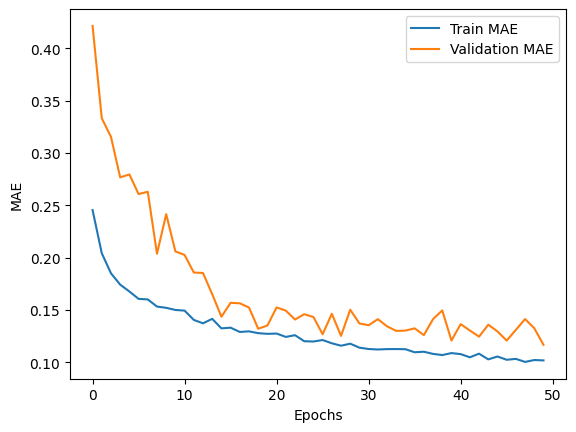

In [10]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Based on this expirement, now we have a model which its results better than target with 2%, as the target is 68K and mae of the valdiation is almost 66K.

#### Activation Function

tanh

In [9]:

early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Define the model
model = Sequential([
    LSTM(512, activation='tanh', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[early_stop])


Epoch 1/50
4365/4365 [==============================] - 405s 90ms/step - loss: 0.1539 - mae: 0.2503 - val_loss: 0.3455 - val_mae: 0.4805
Epoch 2/50
4365/4365 [==============================] - 381s 87ms/step - loss: 0.1014 - mae: 0.2055 - val_loss: 0.2421 - val_mae: 0.3806
Epoch 3/50
4365/4365 [==============================] - 318s 73ms/step - loss: 0.0668 - mae: 0.1749 - val_loss: 0.1899 - val_mae: 0.3280
Epoch 4/50
4365/4365 [==============================] - 303s 69ms/step - loss: 0.0627 - mae: 0.1713 - val_loss: 0.1248 - val_mae: 0.2434
Epoch 5/50
4365/4365 [==============================] - 290s 66ms/step - loss: 0.0525 - mae: 0.1598 - val_loss: 0.1004 - val_mae: 0.2331
Epoch 6/50
4365/4365 [==============================] - 290s 66ms/step - loss: 0.0497 - mae: 0.1549 - val_loss: 0.0798 - val_mae: 0.2078
Epoch 7/50
4365/4365 [==============================] - 290s 66ms/step - loss: 0.0493 - mae: 0.1543 - val_loss: 0.0723 - val_mae: 0.1979
Epoch 8/50
4365/4365 [===================

540/540 [==============================] - 4s 7ms/step - loss: 0.0298 - mae: 0.1262
Normalized MAE:  0.12616989016532898
Denormalized MAE:  72150.85479039146


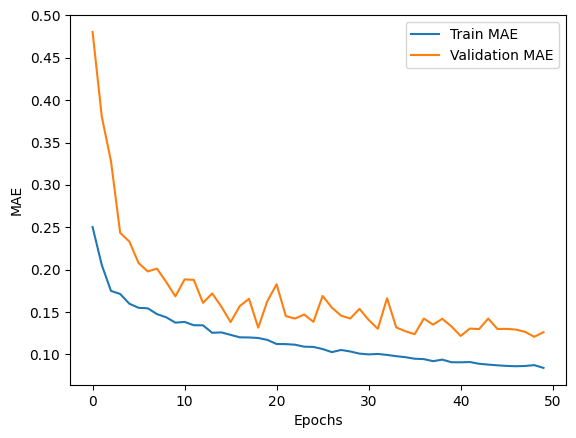

In [10]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

the result is very good when using tanh, but not better than the previous best model

Leaky ReLU

In [15]:

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Define the model with LeakyReLU activation
model = Sequential([
    LSTM(512, input_shape=(seqLength, nFeatures), return_sequences=True),
    LeakyReLU(),
    Dropout(0.2),
    LSTM(256, return_sequences=False),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[early_stop])


Epoch 1/50
4365/4365 [==============================] - 314s 71ms/step - loss: 0.1848 - mae: 0.2670 - val_loss: 0.6055 - val_mae: 0.6461
Epoch 2/50
4365/4365 [==============================] - 302s 69ms/step - loss: 0.1977 - mae: 0.2806 - val_loss: 0.4974 - val_mae: 0.5750
Epoch 3/50
4365/4365 [==============================] - 324s 74ms/step - loss: 0.1902 - mae: 0.2771 - val_loss: 0.4879 - val_mae: 0.5690
Epoch 4/50
4365/4365 [==============================] - 343s 78ms/step - loss: 0.1850 - mae: 0.2747 - val_loss: 0.4823 - val_mae: 0.5613
Epoch 5/50
4365/4365 [==============================] - 341s 78ms/step - loss: 0.1743 - mae: 0.2666 - val_loss: 0.4251 - val_mae: 0.5286
Epoch 6/50
4365/4365 [==============================] - 340s 78ms/step - loss: 0.1720 - mae: 0.2660 - val_loss: 0.4201 - val_mae: 0.5046
Epoch 7/50
4365/4365 [==============================] - 342s 78ms/step - loss: 0.1667 - mae: 0.2607 - val_loss: 0.3695 - val_mae: 0.4487
Epoch 8/50
4365/4365 [===================

540/540 [==============================] - 4s 8ms/step - loss: 0.1054 - mae: 0.2364
Normalized MAE:  0.23641973733901978
Denormalized MAE:  135197.7568972914


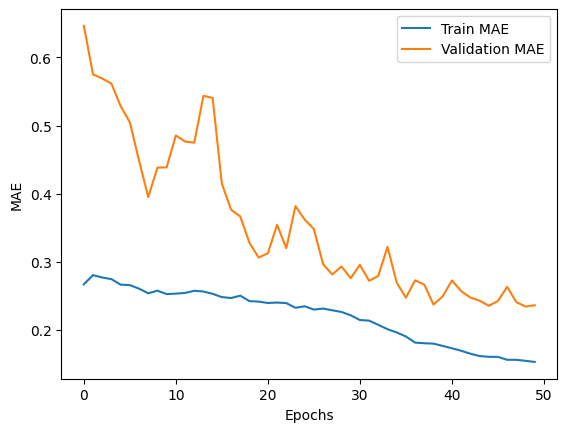

In [16]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)

denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

Altough relu and leaky relu are somehow similar with one main difference when value is zero, but it showed a big difference in the performance in this case, as using the latter yielded the worst model so far

#### Optimizer

rmsprop

In [11]:
# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Define the model
model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# Train the model with early stopping
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[early_stop])

Epoch 1/50
4365/4365 [==============================] - 275s 62ms/step - loss: 0.1489 - mae: 0.2292 - val_loss: 0.4936 - val_mae: 0.5394
Epoch 2/50
4365/4365 [==============================] - 280s 64ms/step - loss: 0.0942 - mae: 0.1903 - val_loss: 0.2850 - val_mae: 0.4114
Epoch 3/50
4365/4365 [==============================] - 276s 63ms/step - loss: 0.0675 - mae: 0.1744 - val_loss: 0.1962 - val_mae: 0.3399
Epoch 4/50
4365/4365 [==============================] - 272s 62ms/step - loss: 0.0571 - mae: 0.1614 - val_loss: 0.1892 - val_mae: 0.3223
Epoch 5/50
4365/4365 [==============================] - 269s 62ms/step - loss: 0.0520 - mae: 0.1548 - val_loss: 0.2112 - val_mae: 0.3265
Epoch 6/50
4365/4365 [==============================] - 268s 61ms/step - loss: 0.0509 - mae: 0.1515 - val_loss: 0.1226 - val_mae: 0.2540
Epoch 7/50
4365/4365 [==============================] - 270s 62ms/step - loss: 0.0502 - mae: 0.1510 - val_loss: 0.1455 - val_mae: 0.2849
Epoch 8/50
4365/4365 [===================

540/540 [==============================] - 4s 8ms/step - loss: 0.0730 - mae: 0.1923
Normalized MAE:  0.1923140287399292
Denormalized MAE:  109975.69660707186


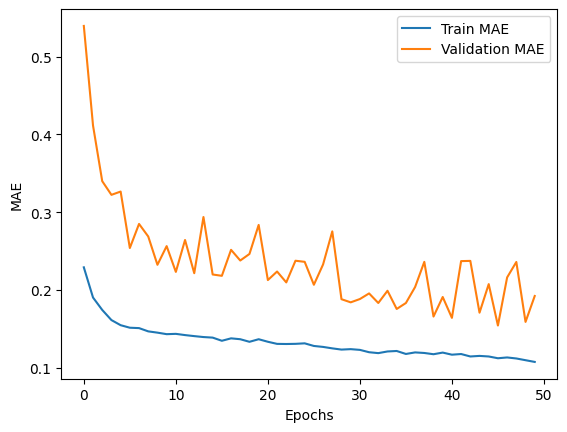

In [12]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

using rmsprop yielded a bad performance (62% error target)

#### Dropout Rate

In [8]:

# Define the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=15)

# Define the model
model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.5),
    LSTM(256, activation='relu', return_sequences=False),
    Dropout(0.5),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[early_stop])


Epoch 1/50
4365/4365 [==============================] - 306s 69ms/step - loss: 0.1926 - mae: 0.2869 - val_loss: 0.4473 - val_mae: 0.5411
Epoch 2/50
4365/4365 [==============================] - 301s 69ms/step - loss: 0.1288 - mae: 0.2433 - val_loss: 0.3740 - val_mae: 0.4837
Epoch 3/50
4365/4365 [==============================] - 309s 71ms/step - loss: 0.1153 - mae: 0.2338 - val_loss: 0.2523 - val_mae: 0.3864
Epoch 4/50
4365/4365 [==============================] - 332s 76ms/step - loss: 0.0994 - mae: 0.2201 - val_loss: 0.2692 - val_mae: 0.3812
Epoch 5/50
4365/4365 [==============================] - 306s 70ms/step - loss: 0.0962 - mae: 0.2159 - val_loss: 0.1794 - val_mae: 0.3127
Epoch 6/50
4365/4365 [==============================] - 296s 68ms/step - loss: 0.0982 - mae: 0.2162 - val_loss: 0.1786 - val_mae: 0.3102
Epoch 7/50
4365/4365 [==============================] - 298s 68ms/step - loss: 0.0855 - mae: 0.2063 - val_loss: 0.1728 - val_mae: 0.3164
Epoch 8/50
4365/4365 [===================

540/540 [==============================] - 5s 9ms/step - loss: 0.0581 - mae: 0.1724
Normalized MAE:  0.17242899537086487
Denormalized MAE:  98604.34522336665


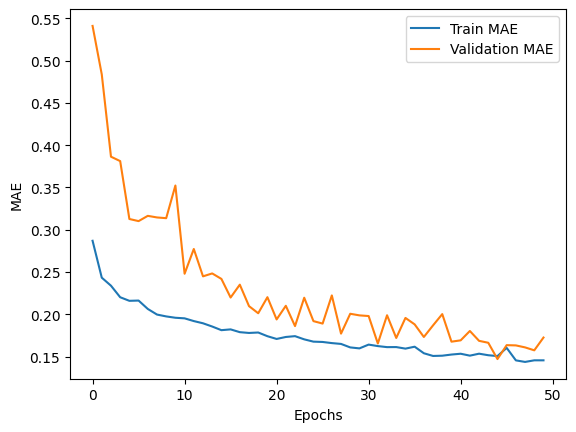

In [9]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

it seems that when dropping half of nuerons instead of 20%, the performance is getting worse, so 20% will be kept

## Best Model

#### Sequence Length

seqLength = 10

In [40]:
#generateTrainTestData(fileName, testPercent, seqLength, batchSize):
#trainData, testData: each element comes from keras.utils.timeseries_dataset_from_array, i.e., is a time series
#Columns: Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment

testPercent = 0.2
seqLength = 10
batchSize = 1
trainData, testData, stdSales, nFeatures = generateTrainTestData("walmart-sales-dataset-of-45stores.csv",
    testPercent, seqLength, batchSize) 

In [41]:


early_stop = EarlyStopping(monitor='val_loss', patience=15)

checkpoint0 = ModelCheckpoint('best_model0.h5', monitor='val_mae', save_best_only=True)

# Define the model
model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.summary()
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model with early stopping and model checkpointing
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[early_stop, checkpoint0])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 10, 512)           1062912   
                                                                 
 dropout_20 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_21 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 257       
                                                                 
Total params: 1,850,625
Trainable params: 1,850,625
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
4185/4185 [=====================

360/360 [==============================] - 4s 10ms/step - loss: 0.0251 - mae: 0.1117
Normalized MAE:  0.11169443279504776
Denormalized MAE:  63872.995299675466


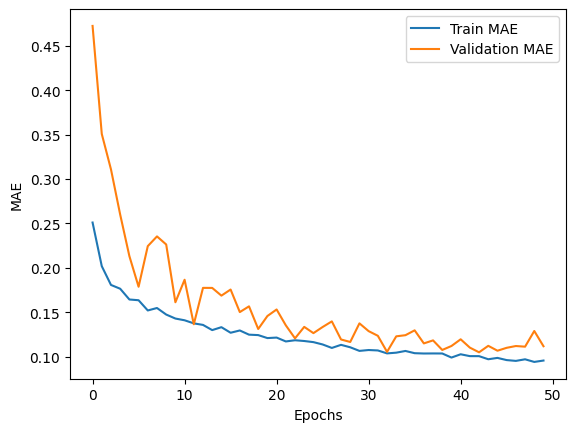

In [42]:
# Evaluate the model
test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

using bigger sequence length yielded a better performance (6% better than target), so it seems it's the time to use the model and try to optimize as much as possible by using smaller learning rate, starting from the best model weights from the last model for another 50 epochs

In [45]:
checkpoint1 = ModelCheckpoint('best_model1.h5', monitor='val_mae', save_best_only=True)

# create a new instance of your model
model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# compile the model with a lower learning rate
lr = 0.001
optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# load the weights of the best model saved during training
model.load_weights('best_model0.h5')

# continue training the model with a lower learning rate
history = model.fit(trainData, epochs=50, validation_data=testData, callbacks=[checkpoint1])


Epoch 1/50
4185/4185 [==============================] - 304s 72ms/step - loss: 0.0185 - mae: 0.0987 - val_loss: 0.0242 - val_mae: 0.1102
Epoch 2/50
4185/4185 [==============================] - 306s 73ms/step - loss: 0.0172 - mae: 0.0958 - val_loss: 0.0254 - val_mae: 0.1120
Epoch 3/50
4185/4185 [==============================] - 317s 76ms/step - loss: 0.0193 - mae: 0.0983 - val_loss: 0.0236 - val_mae: 0.1124
Epoch 4/50
4185/4185 [==============================] - 325s 78ms/step - loss: 0.0179 - mae: 0.0966 - val_loss: 0.0254 - val_mae: 0.1138
Epoch 5/50
4185/4185 [==============================] - 347s 83ms/step - loss: 0.0190 - mae: 0.0989 - val_loss: 0.0247 - val_mae: 0.1152
Epoch 6/50
4185/4185 [==============================] - 325s 78ms/step - loss: 0.0177 - mae: 0.0967 - val_loss: 0.0250 - val_mae: 0.1143
Epoch 7/50
4185/4185 [==============================] - 339s 81ms/step - loss: 0.0173 - mae: 0.0959 - val_loss: 0.0287 - val_mae: 0.1186
Epoch 8/50
4185/4185 [===================

In [46]:
model.load_weights('best_model0.h5')


test_loss, test_mae = model.evaluate(testData)
print("Normalized MAE: ", test_mae)


denormalized_mae = test_mae * stdSales
print("Denormalized MAE: ", denormalized_mae)

360/360 [==============================] - 6s 18ms/step - loss: 0.0218 - mae: 0.1049
Normalized MAE:  0.10485846549272537
Denormalized MAE:  59963.81472152464


Based on the results above, the mae now is lower than 60K, hitting 59,963 which is 12% better than target, I think this is enough and this model will be conisdered, as the model is already too complex and costs a lot, while the final results showed an accepted performace. 

## Conclusion

Based on all previous expirements with 13 different models, the best shown model used the following Architecture:

    model = Sequential([
    LSTM(512, activation='relu', input_shape=(seqLength, nFeatures), return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation='relu', return_sequences=False),
    Dropout(0.2), 
    Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

in addition tu using early stopping and sequence length of 10. 

Target Value : 68,000
Best Model Mean Square Error: 59,963 (12% better)

Please see the below summary table:

| <strong>Model</strong> | <strong>Changes</strong> | <strong>MAE</strong> | <strong>Error to target</strong> |
|------------------------|--------------------------|---------------------|---------------------------------|
| LSTM1                  | Architecture             | 83,949              | 23%                              |
| GRU                    | Architecture             | 90,992              | 34%                              |
| LSTM+CNN               | Architecture             | 99,996              | 47%                              |
| LSTM+Dense             | Architecture             | 114,751             | 69%                              |
| LSTM2                  | more nuerons             | 76,293              | 12%                              |
| LSTM3                  | more nuerons             | 74,021              | 9%                               |
| LSTM4                  | more nuerons             | 71,581              | 5%                               |
| LSTM5                  | more nuerons             | 66,812              | -2%                              |
| LSTM6                  | tanh                     | 72,150              | 6%                               |
| LSTM7                  | rmsprop                  | 109,975             | 62%                              |
| LSTM8                  | LeakyReLU                | 135,197             | 99%                              |
| LSTM9                  | Dropout (0.5)            | 98,604              | 45%                              |
| LSTM10                 | seqLength = 10           | 63,872              | -6%                              |
| LSTM11                 | seqLength = 12           | 68,853              | 1%                               |
| LSTM10.1               | The best model obtained from the model LSTM10 | 59,963 | <span style="color:green">-12%                 |


Some insights can be obtained based on the expirements:

- Using Dense combination with LSTM yielded the worst basic model
- It might be the case that the obtained model is not the best one, as there is possibility that the initial models were not fair enough for a specific combinations, but based on the considered approach and the final result at the end, we can be sure that we have a robust model with accepted performance now
- using more nuerons yielded a better performance, that indicates that as the model is more complex, it behaves better.
- using activation function is critical process, because all functions were used except for reul, have resulted in very bad perforamnce
- when using higher sequence length, the model becomes more compelx and therefore takes more time, but can have a better result than lower number. 
